# Introduction

## Goals

* Measure the numerical precision of [fmriprep](https://github.com/nipreps/fmriprep)

## Methods

* Processed session `ses-001` of subject `sub-032633` in [SIMON dataset](https://portal.conp.ca/dataset?id=projects/SIMON-dataset)
* fmriprep options:
`--random-seed 1234 --fs-no-reconall --anat-only`
* fmriprep container was patched ([Dockerfile](https://github.com/glatard/fmriprep-1/blob/master/Dockerfile_fuzzy), build on Feb 24) with "fuzzy" libmath introducing random perturbations in the least-significant bit of floating-point numbers (inputs and outputs of functions manipulating floating-point numbers).
* This numerical perturbation is supposed to simulate the effect of OS updates

# Utils

In [1]:
import numpy as np
import nibabel as nib
import os
import glob
import subprocess
from IPython.display import Image
import ffmpeg

from nilearn import plotting as nilp
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
input_dir = os.path.join(os.getcwd(), "..", "..", "inputs", "fmriprep")
input_dir = os.path.join(input_dir, "{sampling}", "fmriprep_{dataset}_{ii}", "fmriprep", "{participant}", "{scan}")
output_dir = os.path.join(os.getcwd(), "..", "..", "outputs")
output_dir = os.path.join(output_dir, "{sampling}", "fmriprep_{dataset}", "fmriprep", "{participant}")
output_template = "MNI152NLin2009cAsym"
glob_anat_path = os.path.join(input_dir, f"*{output_template}_desc-preproc_T1w.nii.gz")
glob_func_path = os.path.join(input_dir, f"*{output_template}_desc-preproc_bold.nii.gz")
glob_mask_path = os.path.join(input_dir, f"*{output_template}_desc-brain_mask.nii.gz")
glob_seg_wm_path = os.path.join(input_dir, f"*{output_template}_label-WM_probseg.nii.gz")

In [3]:
n_samples = 5
sampling = "ieee"
participant = "sub-CTS201"
dataset = "ds000256"
scan = "anat"

In [4]:
# From https://raw.githubusercontent.com/gkpapers/2020AggregateMCA/master/code/utils.py
def sigdig(array, base=2, axis=-1):
    '''
    Compute significant digits of array elements along axis
    '''
    try:
        # If we have a float, this is our value of epsilon
        eps = np.finfo(array.dtype).eps
    except ValueError:
        # If it's an int, we want to convert it to a float of the same number of
        # bits to get our estimate of epsilon
        a2_dtype = "np.float{0}".format(array.dtype.itemsize*8)
        a2 = array.astype(eval(a2_dtype))
        warnings.warn("Converting array from {} to {}".format(array.dtype,
                                                              a2.dtype),
                      Warning)
        # Re-call the function with the float version
        return sigdig(a2, base=base, axis=axis)

    # Initialize empty matrix the same size of the array
    shp = list(array.shape)
    shp.pop(axis)
    sigs = np.empty(shp)
    sigs[:] = np.NaN

    # Compute the standard deviation and handle special case 1:
    #   - if no variance, maximum significance
    sd = np.std(array, axis=axis)
    c1locs = np.where(sd == 0)
    sigs[c1locs] = -np.log(eps)/np.log(base)

    # Compute the mean and handle special case 2:
    #   - if mean of 0, no significance.
    #   - N.B. this is the incorrect formula for zero-centered data
    mn = np.mean(array, axis=axis)
    c2locs = np.where(mn == 0)
    for c2l in zip(*c2locs):
        if np.isnan(sigs[c2l]):
            sigs[c2l] = 0

    # Otherwise, compute the number of significant digits using Parker, 1997
    c3locs = np.where(np.isnan(sigs))
    for c3l in zip(*c3locs):
        sigs[c3l] = -np.log(np.abs(sd[c3l] / mn[c3l]) + eps)/np.log(base)

    # Reset any negative values to zero
    c4l = np.where(sigs <= 0)
    sigs[c4l] = 0

    # Round up to nearest full bit, and return
    sigs = np.ceil(sigs).astype(int)
    return sigs

In [5]:
# plotting utility
def plot_array(array, affine, cmap=mpl.cm.viridis):
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 8))
    ni_img = nib.Nifti1Image(array, affine)

    #fig.suptitle("(b) Distributions of significant bits averaged among 20 subjects on MNI space", fontsize=14)
    nilp.plot_img(ni_img, draw_cross=False, cmap=cmap, axes=axes,
                  annotate=False, black_bg=False, colorbar=True)

In [6]:
def view_sig_dig(array, mask, affine, participant="sub-0000", dataset="ds00000", category="raw"):  
    # Get significant digits and extract mean
    sigdigs = sigdig(array, base=10, axis=0)
    mean_sigdig = np.mean(sigdigs[mask])
    print("The average number of significant digits for {category} {sub} in {ds} is {sd:.3f} on a scale of 16 (higher means less difference).".format(
        sub=participant
        , ds=dataset
        , sd=mean_sigdig
        , category=category))
    # Plot masked sigdigits
    masked_sigdigs = np.where(mask, sigdigs, 0)
    ni_img = nib.Nifti1Image(masked_sigdigs, affine)
    
    return nilp.view_img(ni_img, cmap=mpl.cm.viridis, symmetric_cmap=False, bg_img=False, black_bg=True, title="{ds}_{sub} {category}".format(
                ds=dataset
                , sub=participant
                , category=category))

In [7]:
def plot_visual_diff(array, mask, affine, gif_dir="./", category="raw"):
    n_samples = array.shape[0]
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)

    for ii in range(n_samples):
            masked_img = np.where(mask, array[ii], 0)
#             nib.save(nib.Nifti1Image(masked_img, affine), os.path.join(f'{gif_dir}/masked_img_{ii}.nii.gz'))
#             nib.save(nib.Nifti1Image(masks[ii].astype(np.float32), affine), os.path.join(f'{gif_dir}/mask_{ii}.nii.gz'))
#             nib.save(nib.Nifti1Image(array[ii], affine), os.path.join(f'{gif_dir}/img_{ii}.nii.gz'))
            ni_img = nib.Nifti1Image(masked_img, affine)
#             ni_img = nib.Nifti1Image(array[ii], affine)
            display = nilp.plot_img(ni_img, cmap="gray")
            display.savefig('{gif_dir}/{category}_{ii:03d}.png'.format(gif_dir=gif_dir, ii=ii, category=category))
            display.close()

    process = subprocess.Popen(["ffmpeg", "-framerate", "5", "-y", "-i", f"{gif_dir}/{category}_%03d.png", f"{gif_dir}/{category}_visual_diff.gif"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(process.stdout.read().decode("utf-8"))
    return Image(filename=f"{gif_dir}/{category}_visual_diff.gif")

# Files loading

Inputs variables

In [8]:
n_samples = 5
sampling = "ieee"
participant = "sub-CTS201"
dataset = "ds000256"
scan = "anat"

In [9]:
# Read image and mask files
image_files = []
mask_files = []
seg_wm_files = []
masks = []
images = []
wm_segs = []
for i in range(n_samples):
    # filenames
    mask_file = glob.glob(glob_mask_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    image_file = glob.glob(glob_anat_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    seg_wm_file = glob.glob(glob_seg_wm_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    image_files += [image_file]
    mask_files += [mask_file]
    seg_wm_files += [seg_wm_file]
    # mask loading
    masks += [nib.load(mask_file).get_fdata().astype('bool')]
    # segmentation files
    wm_segs += [nib.load(seg_wm_file).get_fdata()]
    # image loading
    nib_img = nib.load(image_file)
    images += [nib_img.get_fdata()]

masks = np.array(masks)
final_mask = np.array(np.prod(np.float32(masks), axis=0), dtype=np.bool)
images = np.array(images)
wm_segs = np.array(wm_segs)
# affines (should be identical for each category)
affine = nib_img.affine

In [10]:
gif_dir = output_dir.format(sampling=sampling, dataset=dataset, participant=participant)

# Raw differences

### Significant digits

Using the functions defined above, we can now compute the number of significant digits in the images normalized to the MNI template.

The average number of significant digits for raw sub-CTS201 in ds000256 is 3.012 on a scale of 16 (higher means less difference).



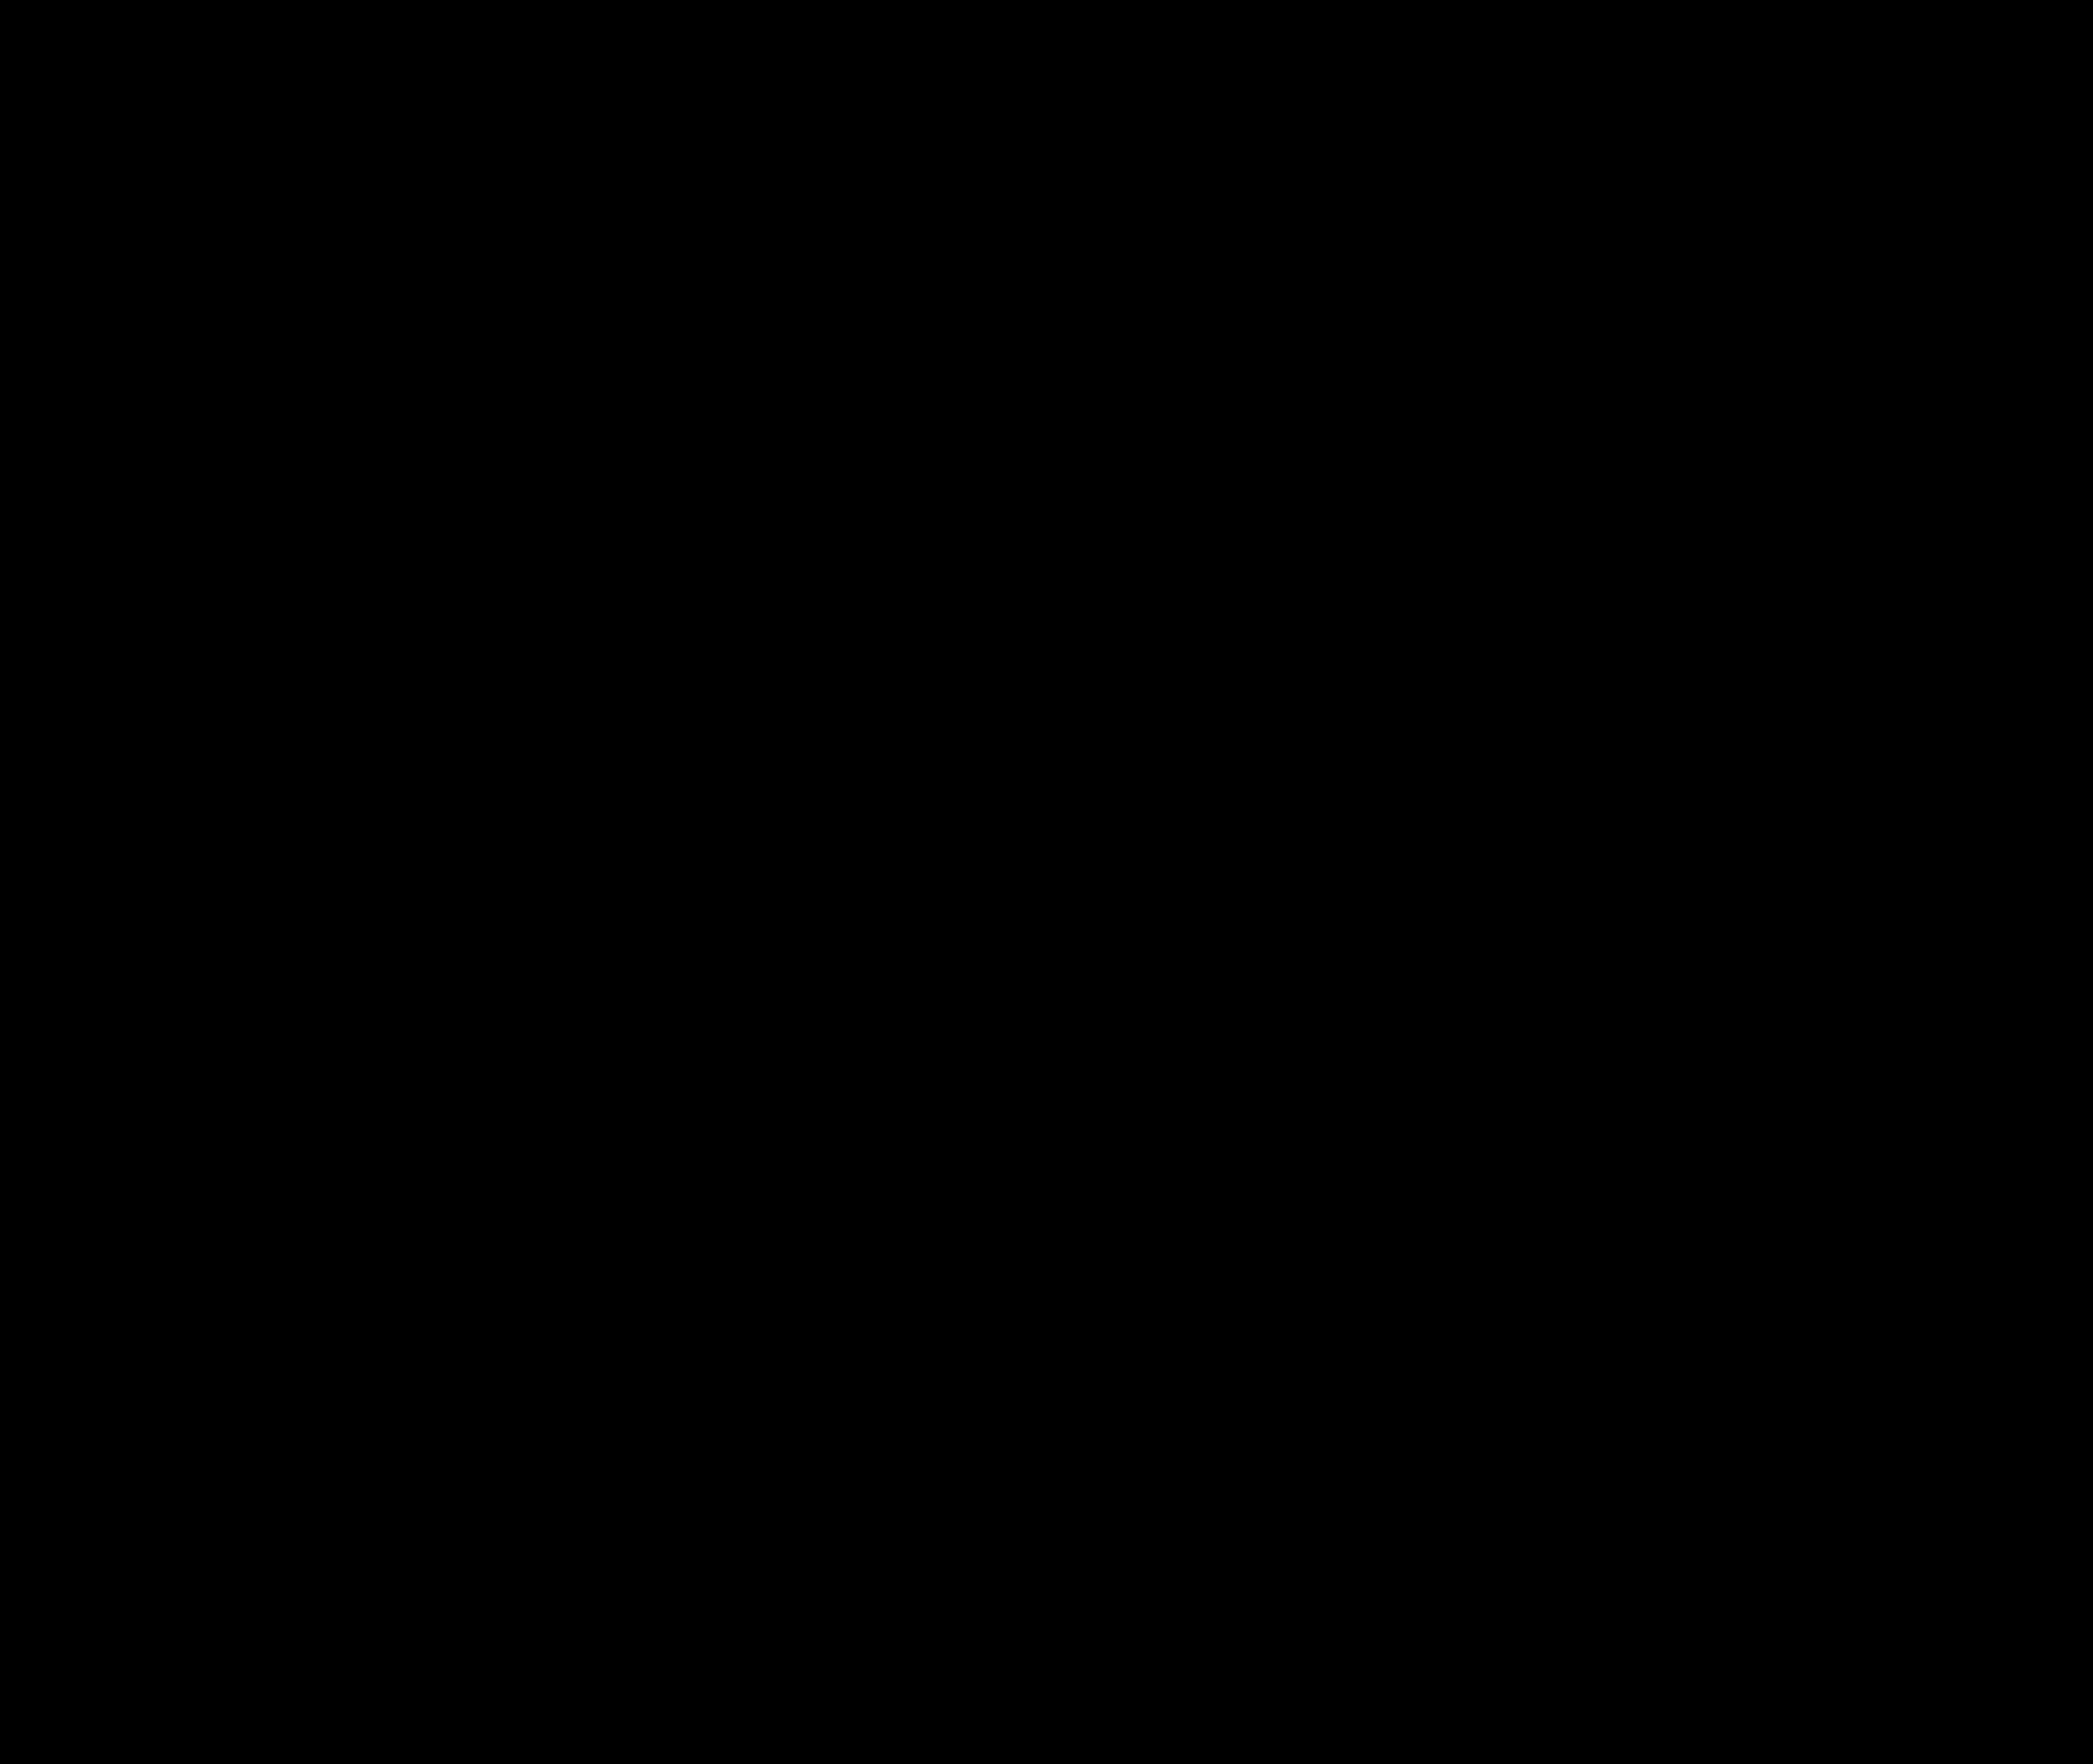
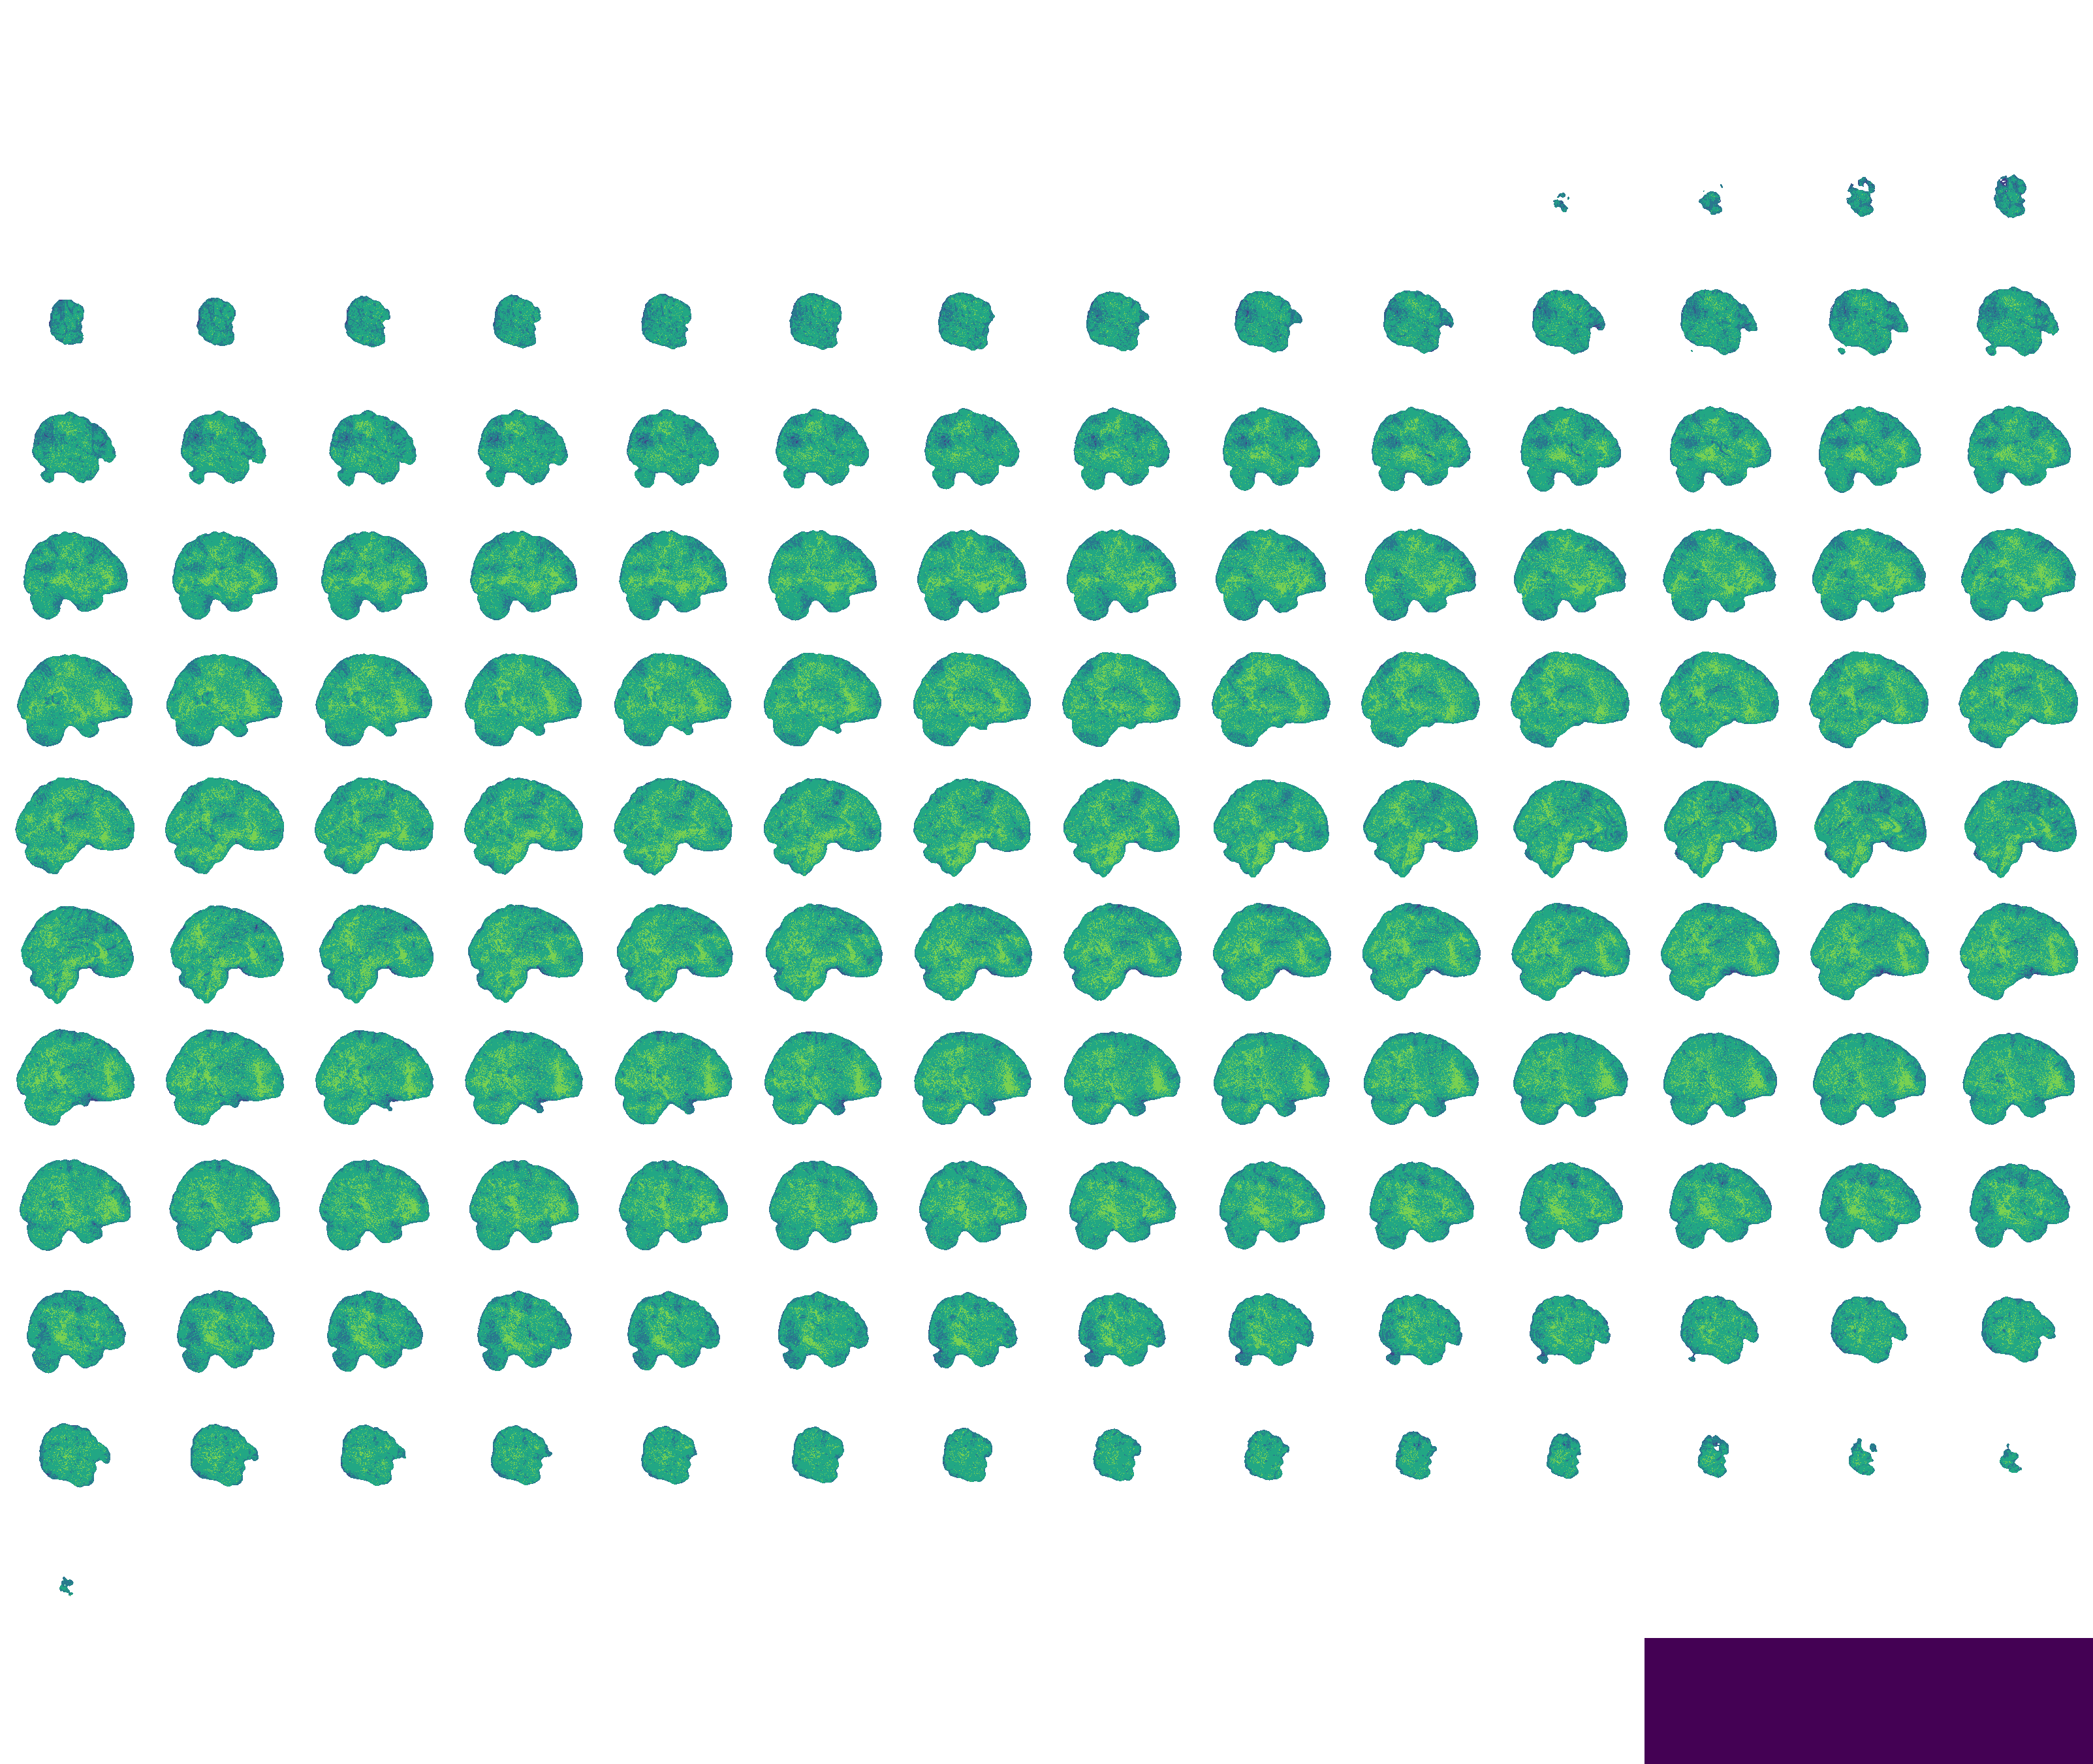

In [11]:
parameters = dict(category="raw", participant=participant, dataset=dataset)
view_sig_dig(images, final_mask, affine, **parameters)

### Visual differences

Apply brain mask of sample 0 to spatially-normalized samples:

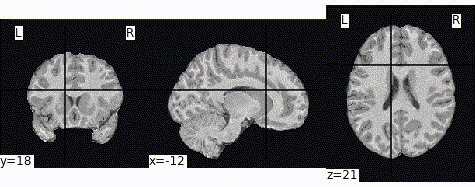

In [12]:
plot_visual_diff(images, final_mask, affine, gif_dir=gif_dir, category=parameters["category"])

In [ ]:
ii=4
masked_img = np.where(masks[ii], images[ii], 0)
ni_img = nib.Nifti1Image(masked_img, affine)
ni_img = nib.Nifti1Image(images[ii], affine)
display = nilp.plot_img(ni_img, cmap="gray")

In [ ]:
masks[ii].shape

In [ ]:
masked_img.shape

In [ ]:
# debug
gif_dir = output_dir.format(sampling=sampling, dataset=dataset, participant=participant)
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

for ii in range(n_samples):
    masked_img = np.where(masks[ii], images[ii], 0)
    ni_img = nib.Nifti1Image(masked_img, affines[ii])
    display = nilp.plot_img(ni_img, cmap="gray")
    display.savefig('{gif_dir}/raw_{ii:03d}.png'.format(gif_dir=gif_dir, ii=ii))
    display.close()

process = subprocess.Popen(["ffmpeg", "-framerate", "5", "-y", "-i", f"{gif_dir}/raw_%03d.png", f"{gif_dir}/raw_visual_diff.gif"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
Image(filename=f"{gif_dir}/raw_visual_diff.gif")

# Tissue class probabilities

## White matter

### Significant digits

In [ ]:
parameters = dict(category="wm", participant=participant, dataset=dataset)
view_sig_dig(wm_segs, masks, affines, **parameters)

### Visual differences

In [ ]:
plot_visual_diff(wm_segs, masks, affines, gif_dir=gif_dir, category=parameters["category"])

## Gray matter

In [ ]:
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz"

In [ ]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

# Mean sigdigits
print("Mean sigdigits:", np.mean(sigdigs, where=mask.get_fdata().astype('bool')))

# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

In [ ]:
%%bash
for sample in 0 1 2
do
    FSLOUTPUTTYPE=NIFTI_GZ\
    ./fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\
               mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz\
               ${sample}-GM.nii.gz
done

In [ ]:
# TAKE SCREENSHOT WITH FSL EYES :)

In [ ]:
%%bash
convert -loop 0 0-gm.png 1-gm.png 2-gm.png gm.gif

<img src="./gm.gif"/>

# IEEE (non-perturbed) samples

Let's check that significant digits are maximal for IEEE samples. We changed the following parameters in data processing:
* fmriprep: same as before (including `--random-seed 1234`
* verificarlo: `VFC_BACKENDS='libinterflop_ieee.so'`

## Resampled images

In [ ]:
condition = 'ieee'
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
n_samples = 2

In [ ]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

In [ ]:
# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

In [ ]:
# Mean sigdigits
np.mean(sigdigs, where=mask.get_fdata().astype('bool'))

In [ ]:
# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

oops... Let's check what happened, we're supposed to have identical results in this case. Maybe an issue with how the random seed is set?

# Random seeds

Let's compare the variability obtained with numerical perturbations to the one resulting from using different random seeds (wip).

## Resampled images

In [ ]:
condition = 'seed'
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
n_samples = 3

In [ ]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

In [ ]:
# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

In [ ]:
# Mean sigdigits
np.mean(sigdigs, where=mask.get_fdata().astype('bool'))

In [ ]:
# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

In [ ]:
# Next steps

* Investigate why `--random-seed` doesn't seem to lead to deterministic results 
* Make more samples per dataset
* Add more sessions / subjects
* Extend to functional pipeline
* Conclude on acceptab